In [1]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")


In [2]:
# Load and prepare data
df = pd.read_csv('D:\Python\demand-prediction\Dataset\SKU3.csv')
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index('date', inplace=True)

# Calculate the sizes based on the percentages
total_size = len(df)
train_size = int(total_size * 0.85)
test_size = total_size - train_size

# Split the data into training and test sets
train = df.iloc[:train_size]
test = df.iloc[train_size:]  # Ensures no overlap

In [3]:
# Use Auto-ARIMA to find the best model parameters
auto_arima_model = auto_arima(
    train['sales'], 
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True
)

# Print the best model summary
print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=37443.103, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=38319.863, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=37920.844, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=37454.521, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=38317.863, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=37442.264, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=37445.115, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=37454.439, Time=0.21 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=37441.219, Time=0.99 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=37443.784, Time=0.31 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=37443.337, Time=2.35 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=37442.864, Time=1.56 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=37445.131, Time=0.41 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=37443.284, Time=2.41 sec
 ARIMA(1,1,3)(0,0,0

In [4]:
# Get the best ARIMA order
best_order = auto_arima_model.order
print(f"Best ARIMA order: {best_order}")

Best ARIMA order: (1, 1, 3)


In [5]:
# Set the rolling window size (e.g., 30 days)
window_size = 25
# Initialize a list to store predictions
rolling_predictions = []

# Use only the training data initially
current_training_data = train.copy()

# Loop over the test set to make rolling predictions using the last 30 days of data
for i in range(len(test)):
    # Create a rolling window from the current training data
    rolling_window = current_training_data.iloc[-window_size:]
    
    # Fit ARIMA model on the rolling window data using the best order
    model = ARIMA(rolling_window['sales'], order=best_order).fit()
    
    # Forecast 1 day ahead
    forecast = model.forecast(steps=1).iloc[0]
    
    # Append the forecasted value
    rolling_predictions.append(forecast)
    
    # After making the prediction, add the predicted value to the training data
    new_data = pd.DataFrame({'sales': [forecast]}, index=[test.index[i]])
    current_training_data = pd.concat([current_training_data, new_data])

    # Optional: Print progress every 50 iterations
    if (i+1) % 50 == 0 or (i+1) == len(test):
        print(f"Completed {i+1}/{len(test)} predictions")

# Convert the predictions list to a NumPy array for consistency
rolling_predictions = np.array(rolling_predictions)

Completed 50/274 predictions
Completed 100/274 predictions
Completed 150/274 predictions
Completed 200/274 predictions
Completed 250/274 predictions
Completed 274/274 predictions


In [6]:
import sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
# Calculate MAE, MAPE, MSE, and R2
mae = mean_absolute_error(test['sales'], rolling_predictions)
mape = mean_absolute_percentage_error(test['sales'], rolling_predictions)
mse = mean_squared_error(test['sales'], rolling_predictions)
r2 = r2_score(test['sales'], rolling_predictions)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"R2: {r2:.4f}")

MAE: 84703.6062
MSE: 9038724989.4932
MAPE: 0.3788
R2: -3.6501


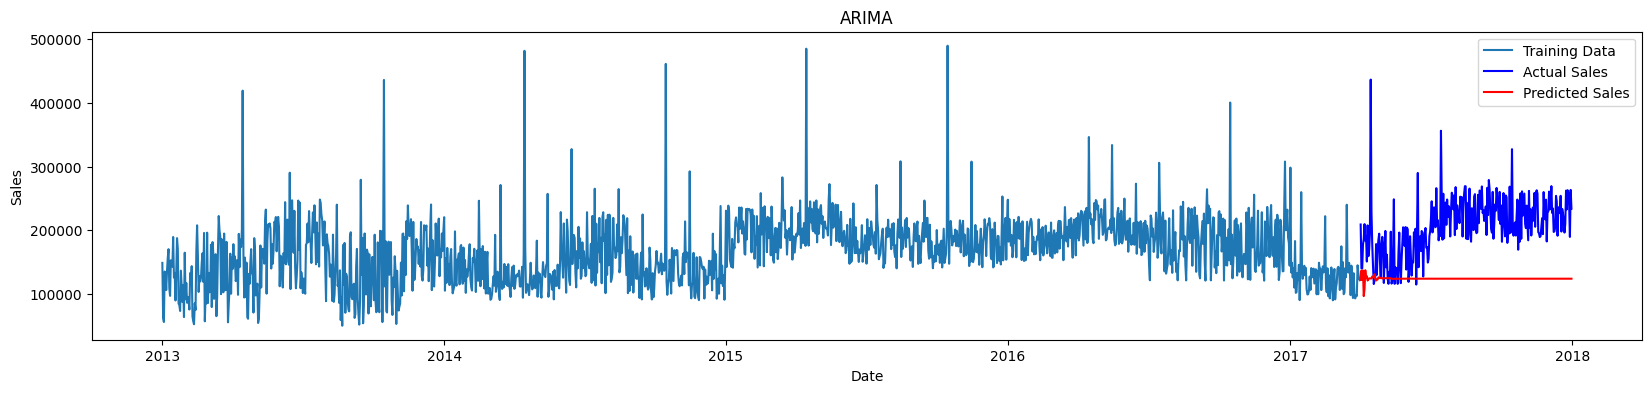

In [7]:
# Plot actual vs predicted sales
plt.figure(figsize=(20,4))
plt.plot(train.index, train['sales'], label='Training Data')
plt.plot(test.index, test['sales'], label='Actual Sales', color='blue')
plt.plot(test.index, rolling_predictions, label='Predicted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA')
plt.legend()
plt.show()

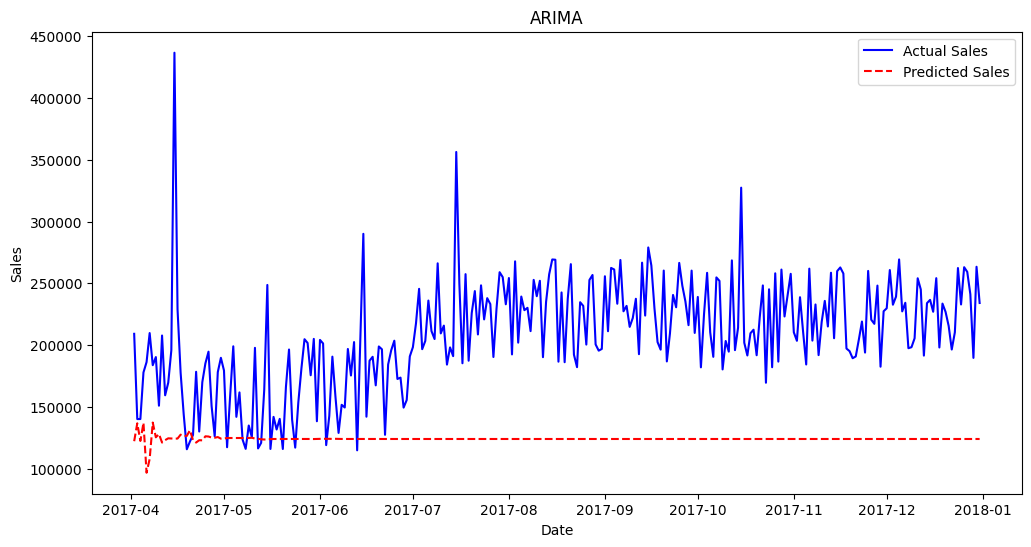

In [8]:
# Plot test set vs predicted sales
plt.figure(figsize=(12,6))
plt.plot(test.index, test['sales'], label='Actual Sales', color='blue')
plt.plot(test.index, rolling_predictions, label='Predicted Sales', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA')
plt.legend()
plt.show()
